<a href="https://colab.research.google.com/github/jeremiah-toribio/ethy-prophet/blob/main/eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# yahoo finance
import yfinance as yf
# personal scripts
import wrangle as w
# prophet model
from prophet import Prophet
# dataframes & matrices
import pandas as pd
import numpy as np
# stats and eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
# viz
import seaborn as sns
import matplotlib.pyplot as plt
# tsa split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
# warnings
import warnings
warnings.filterwarnings("ignore")
# ignore cmdstanpy
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)
# for timing hyperparameter runing loop
from timeit import default_timer as timer
import time



In [2]:
# Personal for saving my data on to my Google Drive

# from google.colab import drive
# drive.mount('drive')

# Acquiring Eth-USD df

In [3]:
eth_usd = yf.Ticker("eth-usd")

In [4]:
pd.DataFrame([eth_usd.info]).T.reset_index()

,index,0
0,twitter,"""https://twitter.com/ethereum"""
1,name,Ethereum
2,startDate,1438905600
3,description,Ethereum (ETH) is a cryptocurrency . Ethereum ...
4,maxAge,86400
5,priceHint,2
6,previousClose,1656.7212
7,open,1656.7212
8,dayLow,1629.4266
9,dayHigh,1656.7212


## <font color='red'>Prior to selecting **3 months** of data, **21 months** was used and price of ethereum has dramatically decreased to be able to get an accurate prediction for a 4 hour time mark </font>

### For concurrency and reproducibility;
<h3 style='background-color=DodgerBlue'> That the amount of data pulled would varie based on the volatility of the historical data </h3>

In [5]:
eth = eth_usd.history(period='3mo',interval='1h')

In [6]:
eth.to_csv('./eth.csv')
!cp eth.csv "drive/My Drive/"


cp: cannot create regular file 'drive/My Drive/': No such file or directory


# Preparing Eth

In [7]:
eth = w.prepare_eth(eth)

# Exploring Eth

<Axes: xlabel='Datetime'>

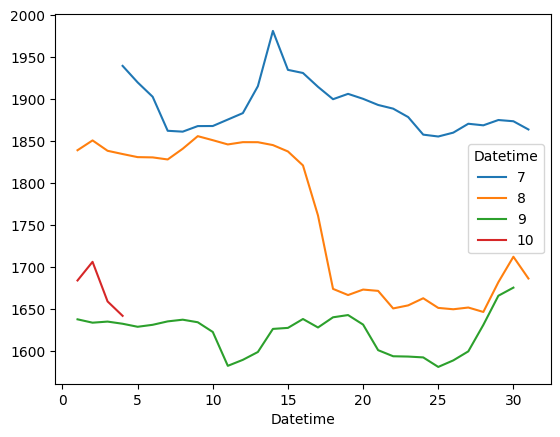

In [8]:
eth.groupby([eth.index.day,eth.index.month])['close'].mean().unstack().plot()

In [9]:
# eth.groupby('month')['close'].mean().plot(kind='bar')

In [10]:
# eth.resample('H').plot(kind='bar')

<Axes: xlabel='Datetime'>

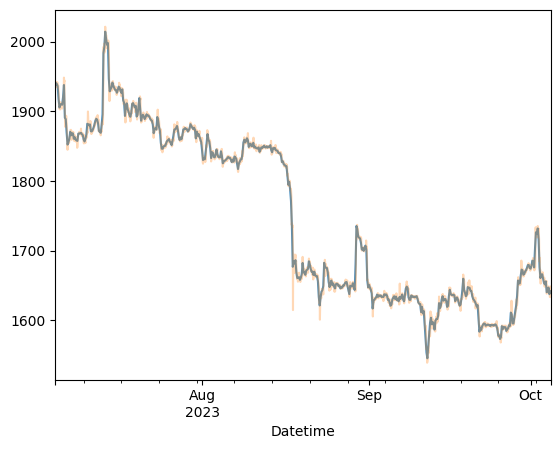

In [11]:
eth.close.resample('4h').mean().plot(alpha=.8)
eth.close.resample('1h').mean().plot(alpha=.3)

# Split

### Humanly determined
-- \
Using **90%** *train* and **10%** *test* \

<font color='blue'>This is determined since the price predicted is only on a 4-hour basis <font>

In [12]:
train_size = int(eth.shape[0] * .9)
test_size = int(eth.shape[0] * .1)

test_end_index = train_size + test_size


In [13]:
train = eth.close[:train_size]
test = eth.close[train_size:test_end_index]

In [14]:
print(f'Train shape: {train.shape}, Test shape: {test.shape} , Eth shape: {eth.shape}')

Train shape: (1988,), Test shape: (220,) , Eth shape: (2209, 9)


In [15]:
# in order to use the prophet model, must rename date as ds and target feature as y
train_model = train.reset_index()
train_model = train_model.rename(columns={'Datetime':'ds', 'close':'y'})
test_model = test.reset_index()
test_model = test_model.rename(columns={'Datetime':'ds', 'close':'y'})

In [16]:
train_model.ds = train_model.ds.astype('datetime64[ns]')
test_model.ds = test_model.ds.astype('datetime64[ns]')
train_model_fit = train_model.copy()

## Split using SKLearn (Did not use)

In [17]:
# dtscv = TimeSeriesSplit(n_splits=3)

In [18]:
# for train_index, test_index in tscv.split(X):

#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Finding Baselines
  - Last Observed Value
  - Simple Average
  - Moving Average

In [19]:
def metrics_dataframe(model,RMSE):
    '''
    Keep track and automatically append data to compare models.
    '''
    metrics_df = pd.DataFrame(data=[
            {
                'model':model,
                'rmse':RMSE
            }
            ])
    return metrics_df

def save_metrics(df, model, RMSE):
    df.loc[len(df)] = [model, RMSE]
    df = df[~df.duplicated('model')]
    return df

## Last Observed

In [20]:
def yhat(col, value):
    yhat_df = pd.DataFrame(
    {col: [value]},
    index=test_model.index)

    return yhat_df

In [21]:
# last item in close
last_close = train[-1:][0]

yhat_df = yhat(col='close',value=last_close)


In [22]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.close))

In [23]:
metrics_df = metrics_dataframe(model = 'last-observed' ,RMSE=score)

In [24]:
metrics_df

,model,rmse
0,last-observed,83.693291


## Simple Average

In [25]:
# last item in close
close_avg = train.mean()

yhat_df = yhat(col='simple-avg',value=close_avg)

In [26]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df['simple-avg']))

In [27]:
save_metrics(df=metrics_df,model='simple-avg', RMSE=score)

,model,rmse
0,last-observed,83.693291
1,simple-avg,120.094080


## Moving Average

In [28]:
period = 4

# last item in close
rolling = round(train.rolling(period).mean()[-1], 2)

yhat_df = yhat(col='rolling',value=rolling)

In [29]:
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df['rolling']))

In [30]:
save_metrics(df=metrics_df, model = 'moving-avg-4hr',RMSE=score)

,model,rmse
0,last-observed,83.693291
1,simple-avg,120.094080
2,moving-avg-4hr,85.732548


# Parameter Tuning

## Holidays (not used)

In [31]:
# importing US holidays for model date identification

import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2023]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

## Parameter Grid

In [32]:
p_grid = {
          'seasonality_mode':('multiplicative','additive'),
          'holidays_prior_scale':[3,4,5,6,7],
          'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
          'changepoint_range':[0.65,0.70,0.75,0.80,0.85]
          }

grid = ParameterGrid(p_grid)

its = 0
for p in grid:
  its = its+1

print(f'Total number of models: {its}')

Total number of models: 250


In [33]:
model_parameters = pd.DataFrame(columns = ['MAPE','RMSE','Parameters'])
i = 0
total_time = 0
for x in grid:
    start = timer()
    test = pd.DataFrame()
    i += 1
    print(f'Num of Iteration: {i} of {its}')
    print(x)
    np.random.seed(4343)
    train_model_loop =Prophet(
                         changepoint_prior_scale = x['changepoint_prior_scale'],
                         holidays_prior_scale = x['holidays_prior_scale'],
                         seasonality_mode = x['seasonality_mode'],
                         weekly_seasonality= True,
                         daily_seasonality = True,
                         yearly_seasonality= False,
                         #holidays=holiday,
                         interval_width=0.95)
    # train_model_loop.add_country_holidays(country_name='US')

    # Removed holidays due to the low factor of importance for cryptocurrency trading, this resulted in
    # marginal increases to accuracy

    train_model_loop.fit(train_model)
    train_forecast = train_model_loop.make_future_dataframe(periods=4, freq='H',include_history = False)
    train_forecast = train_model_loop.predict(train_forecast)
    pred=train_forecast[['ds','yhat']]
    MAPE = mean_absolute_percentage_error(test_model.y.tail(4),abs(pred[['yhat']]))
    RMSE = sqrt(mean_squared_error(test_model.y.tail(4),abs(pred[['yhat']])))
    print('Mean Absolute Percentage Error(MAPE): +++++++',round(MAPE * 100, 4) )
    print('Root Mean Squared Error(RMSE): +++++++',round(RMSE, 4) )
    end = timer()
    runtime = round(end - start, 2)
    total_time += runtime
    print(f'Time (SECONDS): {runtime}, Total time (SECONDS): {round(total_time, 2)}, Total time (MINUTES): {round(total_time / 60, 2)} ')
    model_parameters = model_parameters.append({'MAPE':round(MAPE * 100, 2),'RMSE':round(RMSE, 2),'Parameters':x},ignore_index=True)


Num of Iteration: 1 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.7078
Root Mean Squared Error(RMSE): +++++++ 44.5082
Time (SECONDS): 1.02, Total time (SECONDS): 1.02, Total time (MINUTES): 0.02 
Num of Iteration: 2 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 3, 'seasonality_mode': 'additive'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.7579
Root Mean Squared Error(RMSE): +++++++ 45.329
Time (SECONDS): 1.05, Total time (SECONDS): 2.07, Total time (MINUTES): 0.03 
Num of Iteration: 3 of 250
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'holidays_prior_scale': 4, 'seasonality_mode': 'multiplicative'}
Mean Absolute Percentage Error(MAPE): +++++++ 2.7078
Root Mean Squared Error(RMSE): +++++++ 44.5082
Time (SECONDS): 1.33, Total time (SECONDS): 3.4, Total time (MINUTES): 0.06 
Num of Iteration: 

In [34]:
saved_params = model_parameters.copy()

In [35]:
pd.set_option('display.max_colwidth', None)

In [36]:
saved_params.sort_values('MAPE',ascending=True,inplace=True)

In [37]:
# exporting hyperparams as csv to save data

saved_params.to_csv('hyperparams.csv')

# Parameter Analysis

Although the range of scores is not far off, parameters that are consistency performing ***worst*** are:
- **'changepoint_prior_scale'** of **0.1**
- **'seasonality_mode'** of **'additive'**

Other parameters did not have consistent results



In [38]:
best_params = saved_params.Parameters.loc[0]
best_params

{'changepoint_prior_scale': 0.1,
 'changepoint_range': 0.65,
 'holidays_prior_scale': 3,
 'seasonality_mode': 'multiplicative'}

# Creating Model with Discovered Parameters

In [39]:
# uses top selection from used grid -- although numerous with same score, just top 1 is used
m = Prophet(**best_params,
            weekly_seasonality= True,
            daily_seasonality = True,
            yearly_seasonality= False,
            interval_width=0.95)

In [40]:
model = m.fit(train_model_fit)

# Test predicted

In [41]:
testmodel_forecast = model.predict(test_model)

## Forecast is created with train set -- it will return yhat and lots of other information that can be used to analyze results further

In [42]:
future = model.make_future_dataframe(periods=4, freq='H')
forecast = model.predict(future)

## Exploring Forecast for train and test

In [43]:
forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-07-04 19:00:00,1930.548560,0.001158,-0.000344,1932.119847
1,2023-07-04 20:00:00,1929.466052,0.001531,-0.000597,1931.267589
2,2023-07-04 21:00:00,1928.383544,0.001892,-0.000663,1930.754076
3,2023-07-04 22:00:00,1927.301036,0.002240,-0.000448,1930.753074
4,2023-07-04 23:00:00,1926.218529,0.002572,-0.000070,1931.038532
...,...,...,...,...,...
1987,2023-09-25 14:00:00,1595.480086,-0.005672,-0.000099,1586.272227
1988,2023-09-25 15:00:00,1595.384252,-0.005760,-0.000152,1585.952191
1989,2023-09-25 16:00:00,1595.288419,-0.005822,-0.000097,1585.846083
1990,2023-09-25 17:00:00,1595.192585,-0.005858,-0.000036,1585.789571


### <font color='orange'>NOTE: We can see that the end of forecast will lead right into the beginning of testmodel_forecast


In [44]:
testmodel_forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-09-25 15:00:00,1595.384252,-0.005760,-0.000152,1585.952191
1,2023-09-25 16:00:00,1595.288419,-0.005822,-0.000097,1585.846083
2,2023-09-25 17:00:00,1595.192585,-0.005858,-0.000036,1585.789571
3,2023-09-25 18:00:00,1595.096751,-0.005867,-0.000110,1585.563438
4,2023-09-25 19:00:00,1595.000917,-0.005847,-0.000344,1585.126110
...,...,...,...,...,...
215,2023-10-04 14:00:00,1574.779972,0.005247,-0.000099,1582.887613
216,2023-10-04 15:00:00,1574.684138,0.005274,-0.000152,1582.749912
217,2023-10-04 16:00:00,1574.588304,0.005287,-0.000097,1582.760187
218,2023-10-04 17:00:00,1574.492470,0.005285,-0.000036,1582.756209


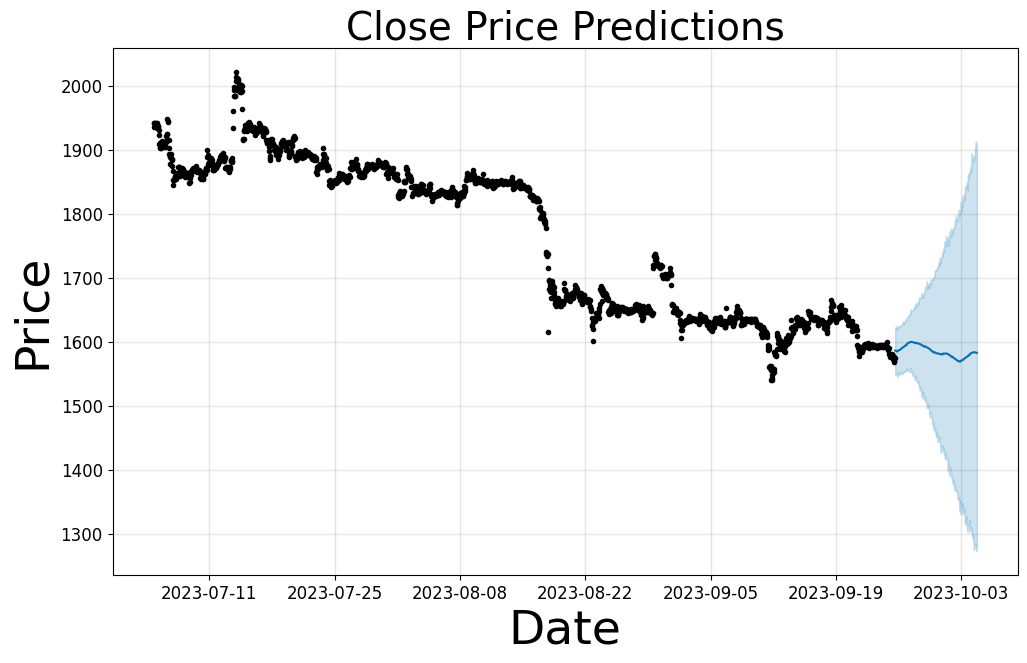

In [60]:
fig = model.plot(testmodel_forecast)
ax = fig.gca()
ax.set_title("Close Price Predictions", size=28)
ax.set_xlabel("Date", size=34)
ax.set_ylabel("Price", size=34)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

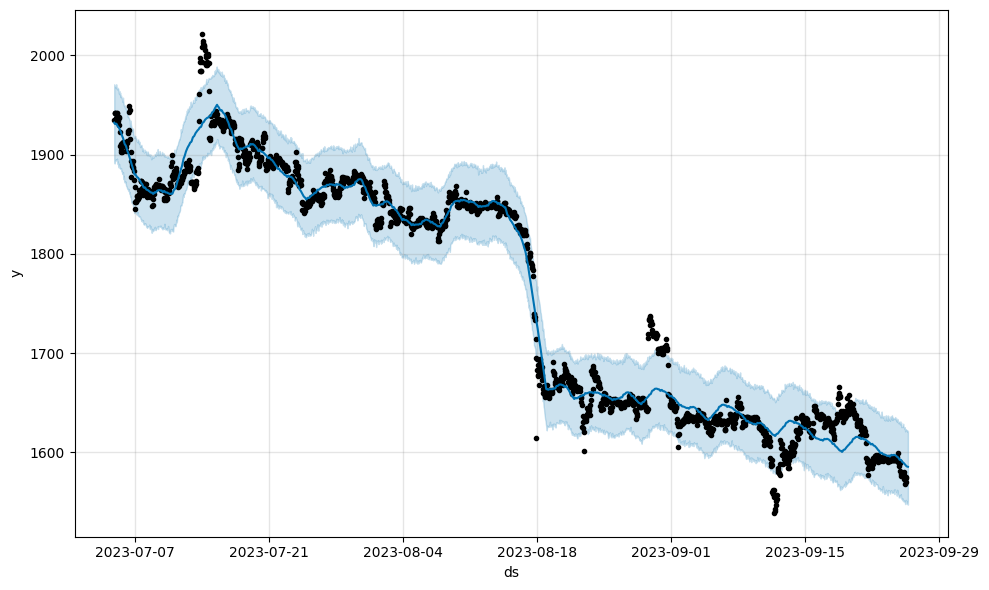

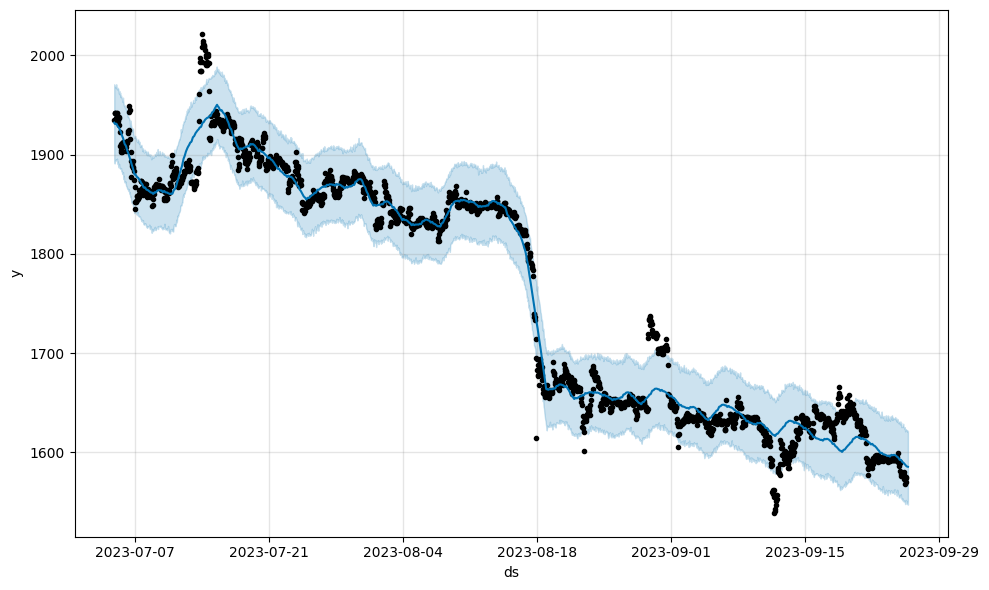

In [62]:
# train on top of actual

m.plot(forecast)

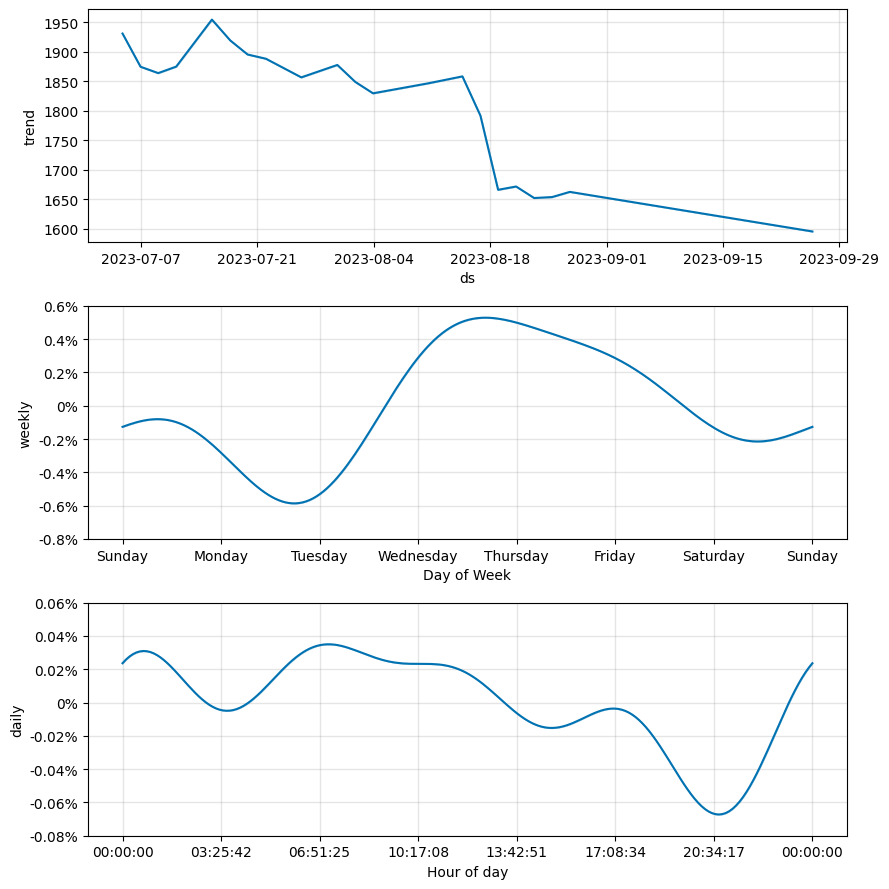

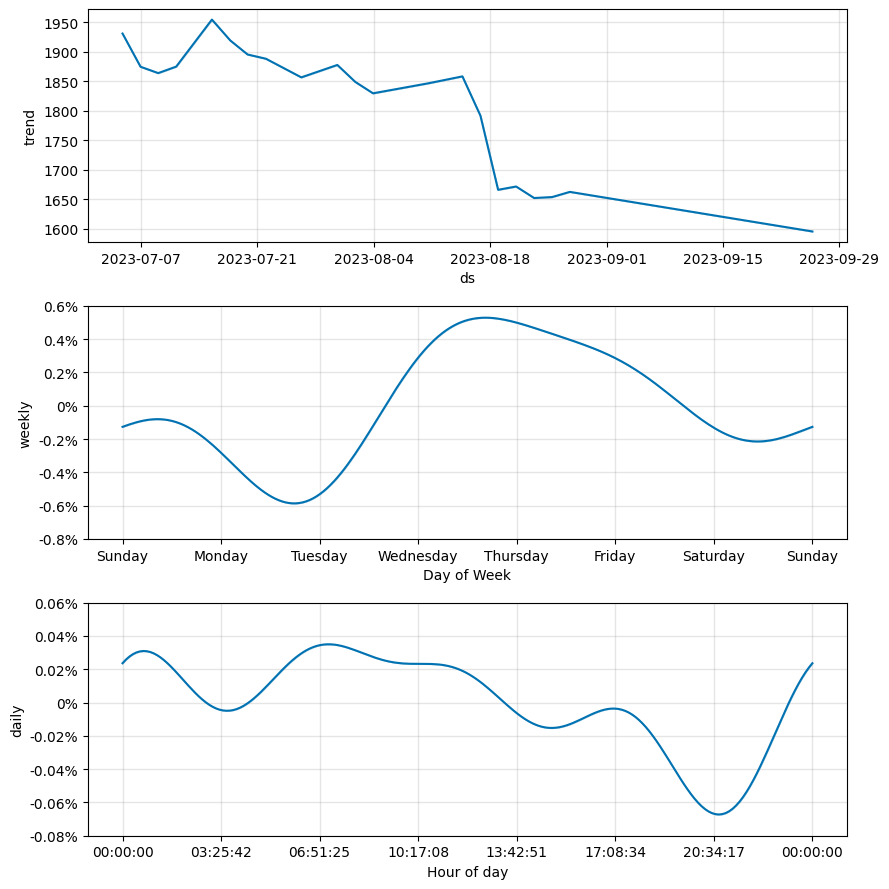

In [47]:
# train components give lots of insight into trend, weekly and daily data

m.plot_components(forecast)